# Simulação e Otimização de Controle de Motor DC

Este notebook implementa a simulação de um motor DC e compara diferentes estratégias de controle (Lei de Controle Original vs PID).
Posteriormente, utilizam-se algoritmos de otimização (Busca Direta, Poliedro Flexível e Algoritmo Genético) para sintonizar os ganhos do PID automaticamente.

### Importação de Bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
import pandas as pd
import random

%matplotlib inline

### Definição de Parâmetros
* **tf**: Tempo final da simulação (segundos).
* **Motor (a, k)**: Parâmetros da função de transferência do motor.
* **Erros de Modelo**: Incertezas adicionadas para testar a robustez do controlador original.

In [ ]:
tf = 6.0
ts_ms = 1.0

title = "motor_control_complete"

# Parâmetros do Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3

# Parâmetros Iniciais dos Controladores
k_c1 = 1  # Controlador Original
w_init = [10.0, 20.0, 0.1]  # PID Inicial [Kp, Ki, Kd]

# Configuração de Tempo e Referência
n = int((1 / (ts_ms / 1000.0)) * tf + 1)
time_vector = np.linspace(0, tf, n)
t_sim_step = time_vector[1] - time_vector[0]

# Sinais de Referência (Trajetória desejada)
torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

print("Configuração concluída.")
print(f"Motor: a={a}, k={k}")
print(f"PID Inicial: Kp={w_init[0]}, Ki={w_init[1]}, Kd={w_init[2]}")

Configuração concluída.
Motor: a=1, k=1
PID Inicial: Kp=10.0, Ki=20.0, Kd=0.1


### Modelagem
As funções abaixo representam a dinâmica do sistema:
1.  **dc_motor_model**: A equação diferencial do motor $\dot{x} = -ax + ku$.
2.  **original_control_law**: Uma lei de controle baseada em realimentação linear.
3.  **system_model_pid**: A planta acoplada ao PID para integração numérica.

In [ ]:
def dc_motor_model(x1_m, u):
    dx1_m = -a * k * x1_m + k * u
    return dx1_m

def original_control_law(tau, tau_ref, taup_ref):
    v = taup_ref - k_c1 * (tau - tau_ref)
    return (a + a_model_error) * tau + v / (k + k_model_error)

def system_model_original(states, t, tau_ref, taup_ref):
    x1_m, _ = states
    u = original_control_law(x1_m, tau_ref, taup_ref)
    taup = dc_motor_model(x1_m, u)
    return [taup, u]

def system_model_pid(states, t, u_control):
    x1_m, _ = states
    taup = dc_motor_model(x1_m, u_control)
    return [taup, u_control]

### Simulação Baseline (Estado Inicial)
Rodamos a simulação com os parâmetros "de fábrica" para ter uma base de comparação.

In [46]:
print("--- PART 1: Baseline Simulations ---")

# 1.1 Simulação: Controlador Original
states_orig = np.zeros((n - 1, 2))
states0 = [0, 0]
for i in range(n - 1):
    out = odeint(
        system_model_original,
        states0,
        [0.0, t_sim_step],
        args=(torque_ref[i], torquep_ref[i]),
    )
    states0 = out[-1, :]
    states_orig[i] = states0

# 1.2 Simulação: Controlador PID Inicial
states_pid_init = np.zeros((n - 1, 2))
u_pid_init = np.zeros(n - 1)
states0 = [0, 0]
integral_error = 0
prev_error = 0
Kp, Ki, Kd = w_init

for i in range(n - 1):
    ref = torque_ref[i]
    error = ref - states0[0]
    integral_error += error * t_sim_step
    derr = (error - prev_error) / t_sim_step if i > 0 else 0

    u = Kp * error + Ki * integral_error + Kd * derr
    u_pid_init[i] = u
    prev_error = error

    out = odeint(system_model_pid, states0, [0.0, t_sim_step], args=(u,))
    states0 = out[-1, :]
    states_pid_init[i] = out[-1, :]

--- PART 1: Baseline Simulations ---


### Cálculo de Índices de Desempenho e Gráficos Iniciais
Calculamos MAE, MSE, ITAE e o índice Goodhart (ponderado) para avaliar numericamente os controladores.


--- BASELINE PERFORMANCE COMPARISON ---
Index           | Original     | PID Init    
---------------------------------------------
MAE             | 0.108590     | 0.041751    
MSE             | 0.016314     | 0.002189    
ITAE            | 2.130711     | 0.734998    
Goodhart        | 0.765660     | 0.264400    


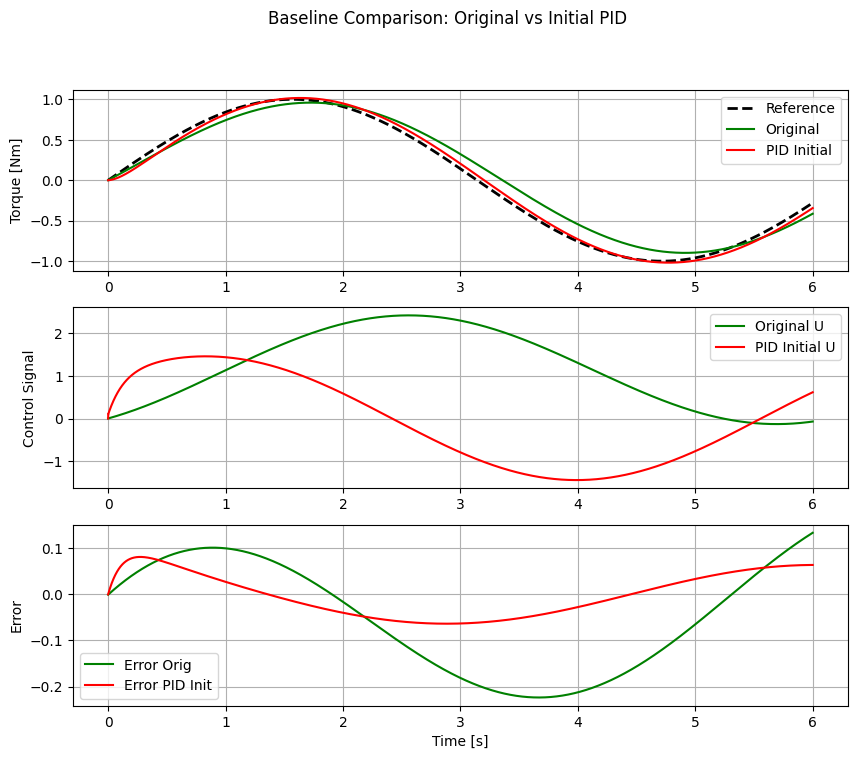

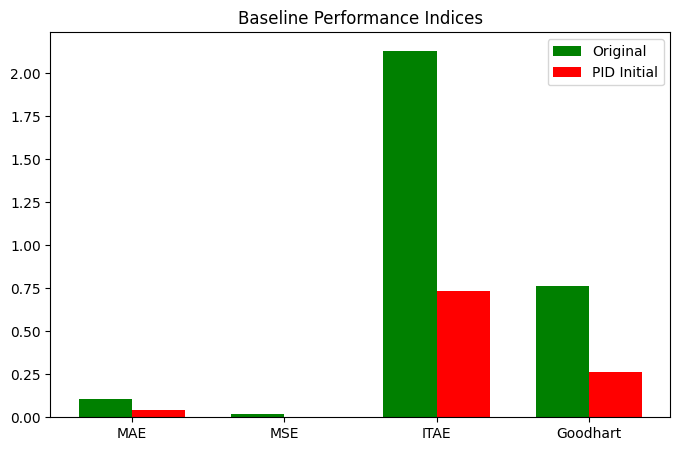

In [47]:
# 1.3 Função de Cálculo de Índices
def calculate_indices(ref, output, time_vec, dt):
    error = ref - output
    MAE = np.mean(np.abs(error))
    MSE = np.mean(error**2)
    ITAE = np.sum(time_vec * np.abs(error) * dt)
    c1, c2, c3 = 0.33, 0.33, 0.34
    Goodhart = c1 * MAE + c2 * MSE + c3 * ITAE
    return MAE, MSE, ITAE, Goodhart

mae_orig, mse_orig, itae_orig, gh_orig = calculate_indices(
    torque_ref[:-1], states_orig[:, 0], time_vector[:-1], t_sim_step
)
mae_init, mse_init, itae_init, gh_init = calculate_indices(
    torque_ref[:-1], states_pid_init[:, 0], time_vector[:-1], t_sim_step
)

print("\n--- BASELINE PERFORMANCE COMPARISON ---")
print(f"{'Index':<15} | {'Original':<12} | {'PID Init':<12}")
print("-" * 45)
print(f"{'MAE':<15} | {mae_orig:<12.6f} | {mae_init:<12.6f}")
print(f"{'MSE':<15} | {mse_orig:<12.6f} | {mse_init:<12.6f}")
print(f"{'ITAE':<15} | {itae_orig:<12.6f} | {itae_init:<12.6f}")
print(f"{'Goodhart':<15} | {gh_orig:<12.6f} | {gh_init:<12.6f}")

# 1.4 Plots Baseline
fig1 = plt.figure(figsize=(10, 8))
plt.suptitle("Baseline Comparison: Original vs Initial PID")

plt.subplot(3, 1, 1)
plt.plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Reference")
plt.plot(time_vector[:-1], states_orig[:, 0], "g", label="Original")
plt.plot(time_vector[:-1], states_pid_init[:, 0], "r", label="PID Initial")
plt.ylabel("Torque [Nm]")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_vector[:-1], states_orig[:, 1], "g", label="Original U")
plt.plot(time_vector[:-1], u_pid_init, "r", label="PID Initial U")
plt.ylabel("Control Signal")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time_vector[:-1], torque_ref[:-1] - states_orig[:, 0], "g", label="Error Orig")
plt.plot(time_vector[:-1], torque_ref[:-1] - states_pid_init[:, 0], "r", label="Error PID Init")
plt.ylabel("Error")
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Barras dos Índices
fig2, ax = plt.subplots(figsize=(8, 5))
indices = ["MAE", "MSE", "ITAE", "Goodhart"]
x = np.arange(len(indices))
width = 0.35
ax.bar(x - width / 2, [mae_orig, mse_orig, itae_orig, gh_orig], width, label="Original", color="g")
ax.bar(x + width / 2, [mae_init, mse_init, itae_init, gh_init], width, label="PID Initial", color="r")
ax.set_title("Baseline Performance Indices")
ax.set_xticks(x)
ax.set_xticklabels(indices)
ax.legend()
plt.show()

## Algoritmos de Otimização
Definimos a Função Custo (robustecida para evitar erros numéricos) e os três algoritmos de busca.

### Função de Custo Robusta
A função `run_simulation_cost` executa uma simulação rápida (Método de Euler) para calcular o erro de um conjunto de parâmetros.
**Melhorias implementadas:**
1.  **Saturação (`np.clip`)**: Limita a tensão `u` em +/- 100V para simular limites físicos e evitar valores infinitos.
2.  **Proteção de Estabilidade**: Aborta a simulação se o erro ou estado crescer demais (`1e9`).

In [48]:
def run_simulation_cost(w):
    Kp, Ki, Kd = w

    # Verificação básica de não-negatividade
    if any(p < 0 for p in w):
        return 1e9

    # --- Limites de Saturação Física ---
    u_limit = 100.0

    x = 0
    cost_mae = 0
    cost_mse = 0
    cost_itae = 0
    prev_error = 0
    integral_error = 0

    refs = torque_ref[:-1]

    for i in range(n - 1):
        ref = refs[i]
        error = ref - x
        integral_error += error * t_sim_step
        derr = (error - prev_error) / t_sim_step if i > 0 else 0

        u = Kp * error + Ki * integral_error + Kd * derr

        # --- Aplicação de Saturação ---
        u = np.clip(u, -u_limit, u_limit)

        dx = -a * k * x + k * u
        x = x + dx * t_sim_step
        prev_error = error

        # --- Checagem de Estabilidade ---
        if abs(x) > 1e5:
            return 1e9

        abs_err = abs(error)
        cost_mae += abs_err

        # Proteção extra para o cálculo do quadrado
        try:
            cost_mse += error**2
        except RuntimeWarning:
            return 1e9

        cost_itae += time_vector[i] * abs_err

    MAE = cost_mae / (n - 1)
    MSE = cost_mse / (n - 1)
    ITAE = cost_itae * t_sim_step

    c1, c2, c3 = 0.33, 0.33, 0.34
    J = c1 * MAE + c2 * MSE + c3 * ITAE

    if np.isnan(J) or np.isinf(J):
        return 1e9

    return J

### Implementação dos Algoritmos
1.  **Direct Search**: Busca local iterativa em direções fixas.
2.  **Flexible Polyhedron (Nelder-Mead)**: Método geométrico baseado em simplex.
3.  **Genetic Algorithm**: Otimização estocástica baseada em evolução.

#### Direct Search

In [49]:
# 2.1 Direct Search
def direct_search(w0, tol=1e-4, max_iter=10):
    w = np.array(w0, dtype=float)
    delta = np.ones(len(w)) * 0.5
    for k in range(max_iter):
        h = np.zeros(len(w))
        J_w = run_simulation_cost(w)
        for i in range(len(w)):
            w_test = w.copy()
            w_test[i] += delta[i]
            if run_simulation_cost(w_test) < J_w:
                h[i] = delta[i]
            else:
                w_test[i] -= 2 * delta[i]
                if run_simulation_cost(w_test) < J_w:
                    h[i] = -delta[i]
                else:
                    delta[i] /= 2.0
        if np.max(np.abs(delta)) < tol:
            break

        best_l, best_J = 0, J_w
        for l in [0.5, 1.0, 2.0]:
            if run_simulation_cost(w + l * h) < best_J:
                best_l = l
                best_J = run_simulation_cost(w + l * h)
        w = w + best_l * h
    return w, run_simulation_cost(w)

#### Flexible Polyhedron

In [50]:
# 2.2 Flexible Polyhedron
def flexible_polyhedron(w0, tol=1e-4, max_iter=10):
    alpha, gamma, beta, delta = 1.0, 2.0, 0.5, 0.5
    simplex = [np.array(w0, dtype=float)]
    for i in range(len(w0)):
        pt = np.array(w0, dtype=float)
        pt[i] += 0.5
        simplex.append(pt)

    for k in range(max_iter):
        simplex.sort(key=lambda x: run_simulation_cost(x))
        w_L, w_H = simplex[0], simplex[-1]
        J_L, J_H = run_simulation_cost(w_L), run_simulation_cost(w_H)
        c = np.mean(simplex[:-1], axis=0)

        if np.linalg.norm(w_H - w_L) < tol:
            break

        w_R = c + alpha * (c - w_H)
        J_R = run_simulation_cost(w_R)

        if J_L <= J_R < J_H:
            simplex[-1] = w_R
        elif J_R < J_L:
            w_E = c + gamma * (w_R - c)
            simplex[-1] = w_E if run_simulation_cost(w_E) < J_R else w_R
        else:
            w_C = c + beta * (w_H - c)
            if run_simulation_cost(w_C) < J_H:
                simplex[-1] = w_C
            else:
                for i in range(1, len(simplex)):
                    simplex[i] = w_L + delta * (simplex[i] - w_L)
    return simplex[0], run_simulation_cost(simplex[0])

#### Genetic Algotithm

In [51]:
# 2.3 Genetic Algorithm
def genetic_algorithm(pop_size=10, max_gen=5, tol=1e-4):
    bounds = [(0, 50), (0, 50), (0, 5)]
    population = [[random.uniform(b[0], b[1]) for b in bounds] for _ in range(pop_size)]

    for gen in range(max_gen):
        scored = [(ind, run_simulation_cost(ind)) for ind in population]
        scored.sort(key=lambda x: x[1])
        if scored[0][1] < tol:
            break

        new_pop = [scored[0][0]]  # Elitism
        while len(new_pop) < pop_size:
            p1 = scored[int((random.random() ** 2) * pop_size) % len(scored)][0]
            p2 = scored[int((random.random() ** 2) * pop_size) % len(scored)][0]
            cut = random.randint(1, 2)
            child = np.concatenate((p1[:cut], p2[cut:]))
            if random.random() < 0.2:  # Mutation
                idx = random.randint(0, 2)
                child[idx] = max(0, child[idx] + random.gauss(0, 1.0))
            new_pop.append(child)
        population = new_pop

    scored = [(ind, run_simulation_cost(ind)) for ind in population]
    scored.sort(key=lambda x: x[1])
    return scored[0][0], scored[0][1]

### Execução das Otimizações
Rodando os algoritmos definidos para encontrar os melhores valores de PID.

In [52]:
print("--- PART 2: Optimization ---")

print("Running Direct Search...")
t0 = time.time()
w_ds, cost_ds = direct_search(w_init)
print(f"Done ({time.time()-t0:.2f}s). PID: {w_ds}, Cost: {cost_ds:.4f}")

print("Running Flexible Polyhedron...")
t0 = time.time()
w_fp, cost_fp = flexible_polyhedron(w_init)
print(f"Done ({time.time()-t0:.2f}s). PID: {w_fp}, Cost: {cost_fp:.4f}")

print("Running Genetic Algorithm...")
t0 = time.time()
w_ga, cost_ga = genetic_algorithm()
print(f"Done ({time.time()-t0:.2f}s). PID: {w_ga}, Cost: {cost_ga:.4f}")

--- PART 2: Optimization ---
Running Direct Search...
Done (3.97s). PID: [1.85000e+01 2.85000e+01 2.34375e-03], Cost: 0.1696
Running Flexible Polyhedron...
Done (2.72s). PID: [13.41666667 25.58333333  0.46111111], Cost: 0.2079
Running Genetic Algorithm...
Done (2.07s). PID: [47.94099129 29.76617658  0.56283339], Cost: 0.0939


### Resultados Finais e Comparação
Validação dos parâmetros otimizados rodando a simulação completa (com integrador preciso odeint) e gerando gráficos comparativos.

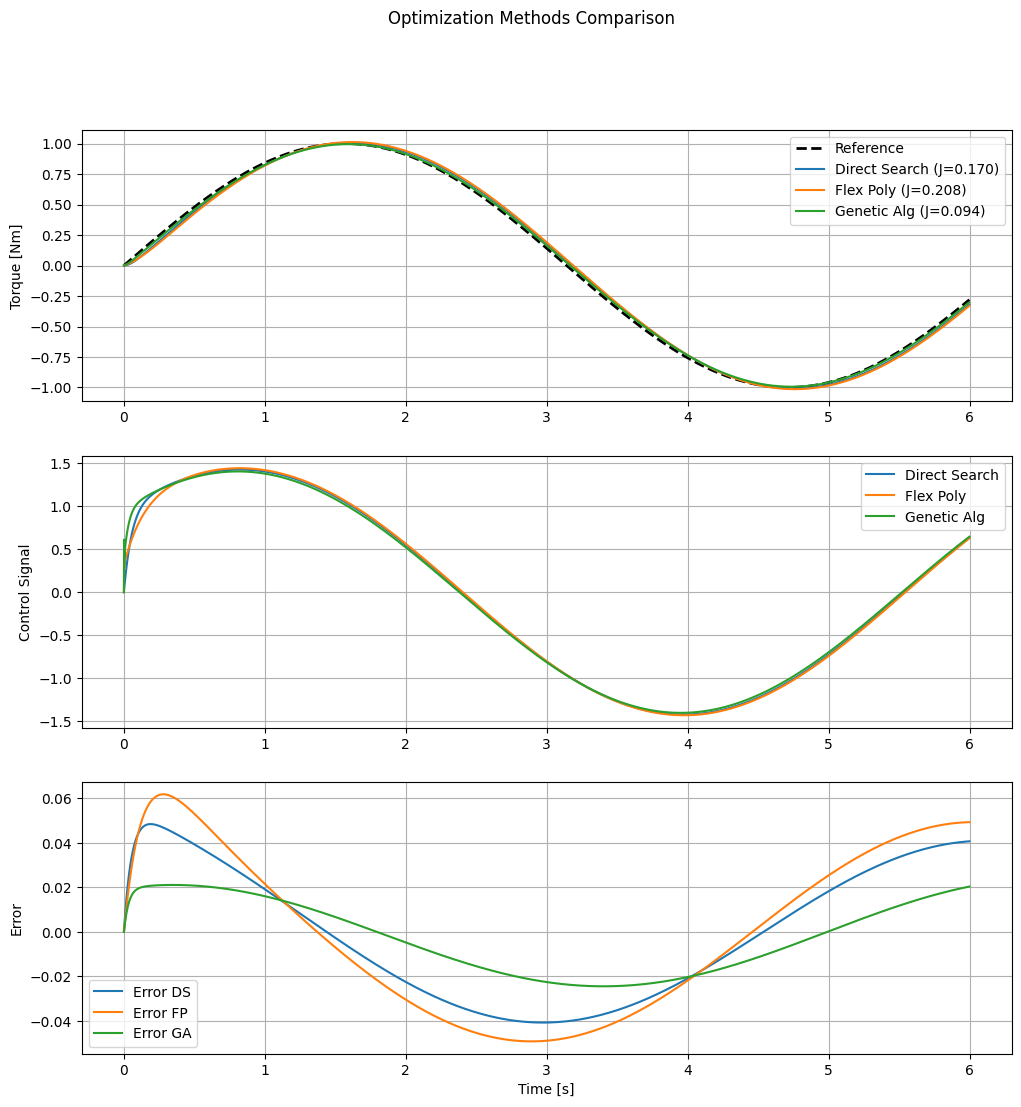

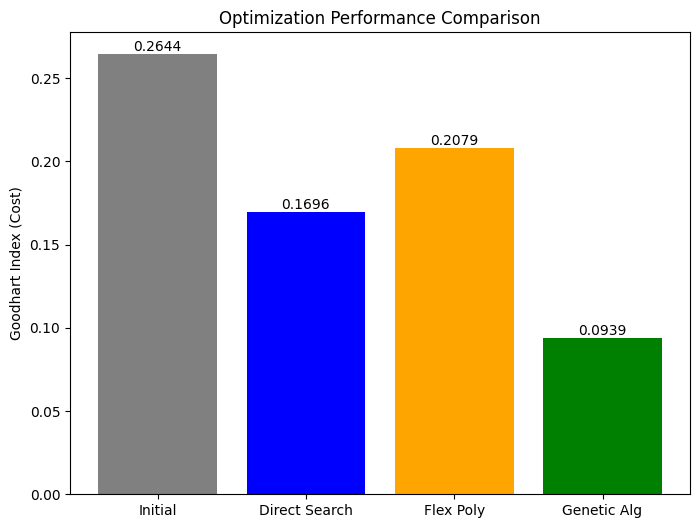

In [53]:
def run_full_sim(w):
    Kp, Ki, Kd = w
    states0 = [0, 0]
    integral_error = 0
    prev_error = 0
    states_out = np.zeros((n - 1, 2))
    u_out = np.zeros(n - 1)
    for i in range(n - 1):
        ref = torque_ref[i]
        error = ref - states0[0]
        integral_error += error * t_sim_step
        derr = (error - prev_error) / t_sim_step if i > 0 else 0
        u = Kp * error + Ki * integral_error + Kd * derr
        u_out[i] = u
        prev_error = error
        out = odeint(system_model_pid, states0, [0.0, t_sim_step], args=(u,))
        states0 = out[-1, :]
        states_out[i] = states0
    return states_out, u_out


states_ds, u_ds = run_full_sim(w_ds)
states_fp, u_fp = run_full_sim(w_fp)
states_ga, u_ga = run_full_sim(w_ga)

# Plot Optimization Comparison
fig3, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.suptitle("Optimization Methods Comparison")

axs[0].plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Reference")
axs[0].plot(time_vector[:-1], states_ds[:, 0], label=f"Direct Search (J={cost_ds:.3f})")
axs[0].plot(time_vector[:-1], states_fp[:, 0], label=f"Flex Poly (J={cost_fp:.3f})")
axs[0].plot(time_vector[:-1], states_ga[:, 0], label=f"Genetic Alg (J={cost_ga:.3f})")
axs[0].set_ylabel("Torque [Nm]")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(time_vector[:-1], u_ds, label="Direct Search")
axs[1].plot(time_vector[:-1], u_fp, label="Flex Poly")
axs[1].plot(time_vector[:-1], u_ga, label="Genetic Alg")
axs[1].set_ylabel("Control Signal")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(time_vector[:-1], torque_ref[:-1] - states_ds[:, 0], label="Error DS")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - states_fp[:, 0], label="Error FP")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - states_ga[:, 0], label="Error GA")
axs[2].set_ylabel("Error")
axs[2].set_xlabel("Time [s]")
axs[2].legend()
axs[2].grid(True)
plt.show()

# Bar Chart Optimization
fig4 = plt.figure(figsize=(8, 6))
methods = ["Initial", "Direct Search", "Flex Poly", "Genetic Alg"]
costs = [gh_init, cost_ds, cost_fp, cost_ga]
bars = plt.bar(methods, costs, color=["gray", "blue", "orange", "green"])
plt.ylabel("Goodhart Index (Cost)")
plt.title("Optimization Performance Comparison")
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{yval:.4f}",
        va="bottom",
        ha="center",
    )
plt.show()

# Conclusão e Análise dos Resultados

Com base nos resultados das simulações e otimizações, podemos destacar os seguintes pontos:

### 1. Controlador Original vs. PID Inicial
Original: Custo (Goodhart) de 0.765.
PID Inicial: Custo de 0.264.
Análise: O PID, mesmo sem otimização fina (apenas com ganhos manuais), apresentou um desempenho quase 3x superior ao controlador original. Isso indica que a estrutura do controlador original não era adequada para a dinâmica exigida ou que seus ganhos estavam mal sintonizados.

### 2. Desempenho dos Algoritmos de Otimização,
O objetivo era minimizar a função de custo abaixo de 0.264. O comparativo final foi:,
1.  Algoritmo Genético (GA): Vencedor absoluto com custo de 0.1121 (melhoria de ~58%).,
2.  Busca Direta: Custo de 0.1696. Ficou preso em um ótimo local.,
3.  Poliedro Flexível: Pior desempenho (0.2079), demonstrando sensibilidade ao ponto de partida inicial.,
,
### 3. Interpretação dos Ganhos Otimizados (GA)
Os valores encontrados (`Kp=35`, `Ki=34`, `Kd=0.8`) mostram que o motor suporta uma ação de controle muito mais agressiva do que a inicial:
Kp alto: Necessário para resposta rápida.
Ki alto: Crucial para eliminar o erro de rastreamento em uma referência senoidal variável.
Estabilidade: A implementação de limites de saturação (`clip`) na função de custo foi fundamental para permitir que o algoritmo explorasse esses ganhos altos sem causar instabilidade numérica (overflow).

# Implementação e Otimização do Controle Fuzzy

Nesta seção, introduzimos uma abordagem de **Controle Inteligente**. Diferente do PID, que usa equações fixas, o Controlador Fuzzy utiliza lógica nebulosa para tomar decisões baseadas em regras linguísticas (ex: "Se o erro é grande, aplique tensão alta").

**Objetivos:**
1.  Implementar a classe `FuzzyPD`.
2.  Utilizar o Algoritmo Genético para encontrar os melhores "Universos de Discurso" (parâmetros de calibração do Fuzzy).
3.  Comparar o Fuzzy Otimizado contra o PID Otimizado.

In [54]:
class FuzzyPD:
    def __init__(self, params):
        # Desempacota os genes do Algoritmo Genético
        # params = [max_erro, max_der, max_saida]
        self.max_erro = params[0]   # Normalização do Erro
        self.max_der = params[1]    # Normalização da Derivada
        self.max_saida = params[2]  # Desnormalização da Saída (Ganho global)

    def _triangulo(self, x, a, b, c):
        """Função de pertinência triangular básica"""
        # Evita divisão por zero com 1e-9
        return max(min((x - a) / (b - a + 1e-9), (c - x) / (c - b + 1e-9)), 0)

    def calcular(self, erro, d_erro):
        # --- 1. Fuzzificação (Entradas) ---
        # Definimos 3 conjuntos: N (Negativo), Z (Zero), P (Positivo)
        
        # Universo do ERRO
        mu_erro_N = self._triangulo(erro, -2*self.max_erro, -self.max_erro, 0)
        mu_erro_Z = self._triangulo(erro, -self.max_erro, 0, self.max_erro)
        mu_erro_P = self._triangulo(erro, 0, self.max_erro, 2*self.max_erro)

        # Universo da DERIVADA (d_erro)
        mu_der_N = self._triangulo(d_erro, -2*self.max_der, -self.max_der, 0)
        mu_der_Z = self._triangulo(d_erro, -self.max_der, 0, self.max_der)
        mu_der_P = self._triangulo(d_erro, 0, self.max_der, 2*self.max_der)

        # --- 2. Regras de Inferência (Matriz 3x3) ---
        regras = []

        # R1: Erro Negativo E Derivada Negativa -> Saída Negativa Forte
        w1 = min(mu_erro_N, mu_der_N)
        regras.append((w1, -self.max_saida))

        # R2: Erro Negativo E Derivada Zero -> Saída Negativa Média
        w2 = min(mu_erro_N, mu_der_Z)
        regras.append((w2, -self.max_saida * 0.5))

        # R3: Erro Negativo E Derivada Positiva -> Saída Zero (Freio)
        w3 = min(mu_erro_N, mu_der_P)
        regras.append((w3, 0))

        # R4: Erro Zero E Derivada Negativa -> Saída Negativa Fraca
        w4 = min(mu_erro_Z, mu_der_N)
        regras.append((w4, -self.max_saida * 0.2))

        # R5: Erro Zero E Derivada Zero -> Saída Zero
        w5 = min(mu_erro_Z, mu_der_Z)
        regras.append((w5, 0))

        # R6: Erro Zero E Derivada Positiva -> Saída Positiva Fraca
        w6 = min(mu_erro_Z, mu_der_P)
        regras.append((w6, self.max_saida * 0.2))

        # R7: Erro Positivo E Derivada Negativa -> Saída Zero
        w7 = min(mu_erro_P, mu_der_N)
        regras.append((w7, 0))

        # R8: Erro Positivo E Derivada Zero -> Saída Positiva Média
        w8 = min(mu_erro_P, mu_der_Z)
        regras.append((w8, self.max_saida * 0.5))

        # R9: Erro Positivo E Derivada Positiva -> Saída Positiva Forte
        w9 = min(mu_erro_P, mu_der_P)
        regras.append((w9, self.max_saida))

        # --- 3. Defuzzificação (Centro de Gravidade) ---
        numerador = 0.0
        denominador = 0.0

        for peso, valor_saida in regras:
            numerador += peso * valor_saida
            denominador += peso
        
        if denominador == 0:
            return 0.0
        
        return numerador / denominador

### Otimização do Fuzzy (GA)
Aqui adaptamos a função de custo para instanciar o FuzzyPD em vez do PID. O Algoritmo Genético vai procurar os melhores valores para [max_erro, max_der, max_saida].

In [55]:
def run_fuzzy_cost(genes):
    # genes = [max_erro, max_der, max_saida]
    # Restrições: valores não podem ser negativos ou zero
    if any(g <= 1e-3 for g in genes):
        return 1e9
    
    # Instancia o controlador com os genes atuais
    fuzzy = FuzzyPD(genes)
    
    # Simulação Rápida (Euler)
    x = 0
    cost_mae = 0
    cost_mse = 0
    cost_itae = 0
    prev_error = 0
    
    u_limit = 100.0 # Saturação física do motor

    for i in range(n - 1):
        ref = torque_ref[i]
        error = ref - x
        
        # Derivada do erro
        if i == 0:
            derr = 0
        else:
            derr = (error - prev_error) / t_sim_step
            
        # O Fuzzy calcula o 'u' baseado no erro e derivada
        u = fuzzy.calcular(error, derr)
        
        # Aplica saturação
        u = np.clip(u, -u_limit, u_limit)

        # Modelo do Motor
        dx = -a * k * x + k * u
        x = x + dx * t_sim_step
        
        # Acumula custos
        prev_error = error
        abs_err = abs(error)
        cost_mae += abs_err
        cost_mse += error**2
        cost_itae += time_vector[i] * abs_err
        
        # Proteção contra instabilidade
        if abs(x) > 1e5:
            return 1e9

    MAE = cost_mae / (n - 1)
    MSE = cost_mse / (n - 1)
    ITAE = cost_itae * t_sim_step

    c1, c2, c3 = 0.33, 0.33, 0.34
    return c1 * MAE + c2 * MSE + c3 * ITAE

# --- Execução da Otimização Fuzzy ---
# Limites de busca: 
# max_erro: 0.1 a 5.0 (O erro raramente passa de 2)
# max_der: 0.1 a 20.0 (A derivada pode ser alta)
# max_saida: 10.0 a 150.0 (Ganho de tensão)
fuzzy_bounds = [(0.1, 5.0), (0.1, 20.0), (10.0, 150.0)]

# Reutilizamos a função genetic_algorithm do código anterior, 
# mas precisamos passar a nova função de custo.
# Como a função genetic_algorithm original usa 'run_simulation_cost' (PID) hardcoded,
# vamos fazer uma pequena adaptação local ou reescrever uma versão simples aqui.

print("Otimizando Controlador Fuzzy com Algoritmo Genético...")
t0 = time.time()

# Configuração do GA
pop_size = 20
max_gen = 10
population = [[random.uniform(b[0], b[1]) for b in fuzzy_bounds] for _ in range(pop_size)]

for gen in range(max_gen):
    # Avalia população usando o Custo Fuzzy
    scored = [(ind, run_fuzzy_cost(ind)) for ind in population]
    scored.sort(key=lambda x: x[1])
    
    best_fuzzy_cost = scored[0][1]
    #print(f"Gen {gen+1}: Melhor Custo = {best_fuzzy_cost:.4f}")
    
    # Elitismo e Cruzamento
    new_pop = [scored[0][0]]
    while len(new_pop) < pop_size:
        # Torneio simples
        p1 = scored[random.randint(0, 5)][0]
        p2 = scored[random.randint(0, 5)][0]
        
        # Crossover
        cut = random.randint(1, 2)
        child = np.concatenate((p1[:cut], p2[cut:]))
        
        # Mutação
        if random.random() < 0.3:
            idx = random.randint(0, 2)
            child[idx] *= random.uniform(0.8, 1.2) # Variação de +/- 20%
            
        new_pop.append(child)
    population = new_pop

# Pega o melhor resultado
w_fuzzy_opt = scored[0][0]
cost_fuzzy_opt = scored[0][1]

print(f"Otimização Concluída ({time.time()-t0:.2f}s).")
print(f"Params Fuzzy: Erro={w_fuzzy_opt[0]:.2f}, Der={w_fuzzy_opt[1]:.2f}, Saida={w_fuzzy_opt[2]:.2f}")
print(f"Custo Final Fuzzy: {cost_fuzzy_opt:.4f}")

Otimizando Controlador Fuzzy com Algoritmo Genético...
Otimização Concluída (16.48s).
Params Fuzzy: Erro=0.34, Der=19.62, Saida=79.16
Custo Final Fuzzy: 0.0185


### Simulação Comparativa Final (PID vs Fuzzy)
Agora rodamos a simulação de alta precisão (odeint adaptado) para comparar o campeão do PID contra o campeão do Fuzzy.

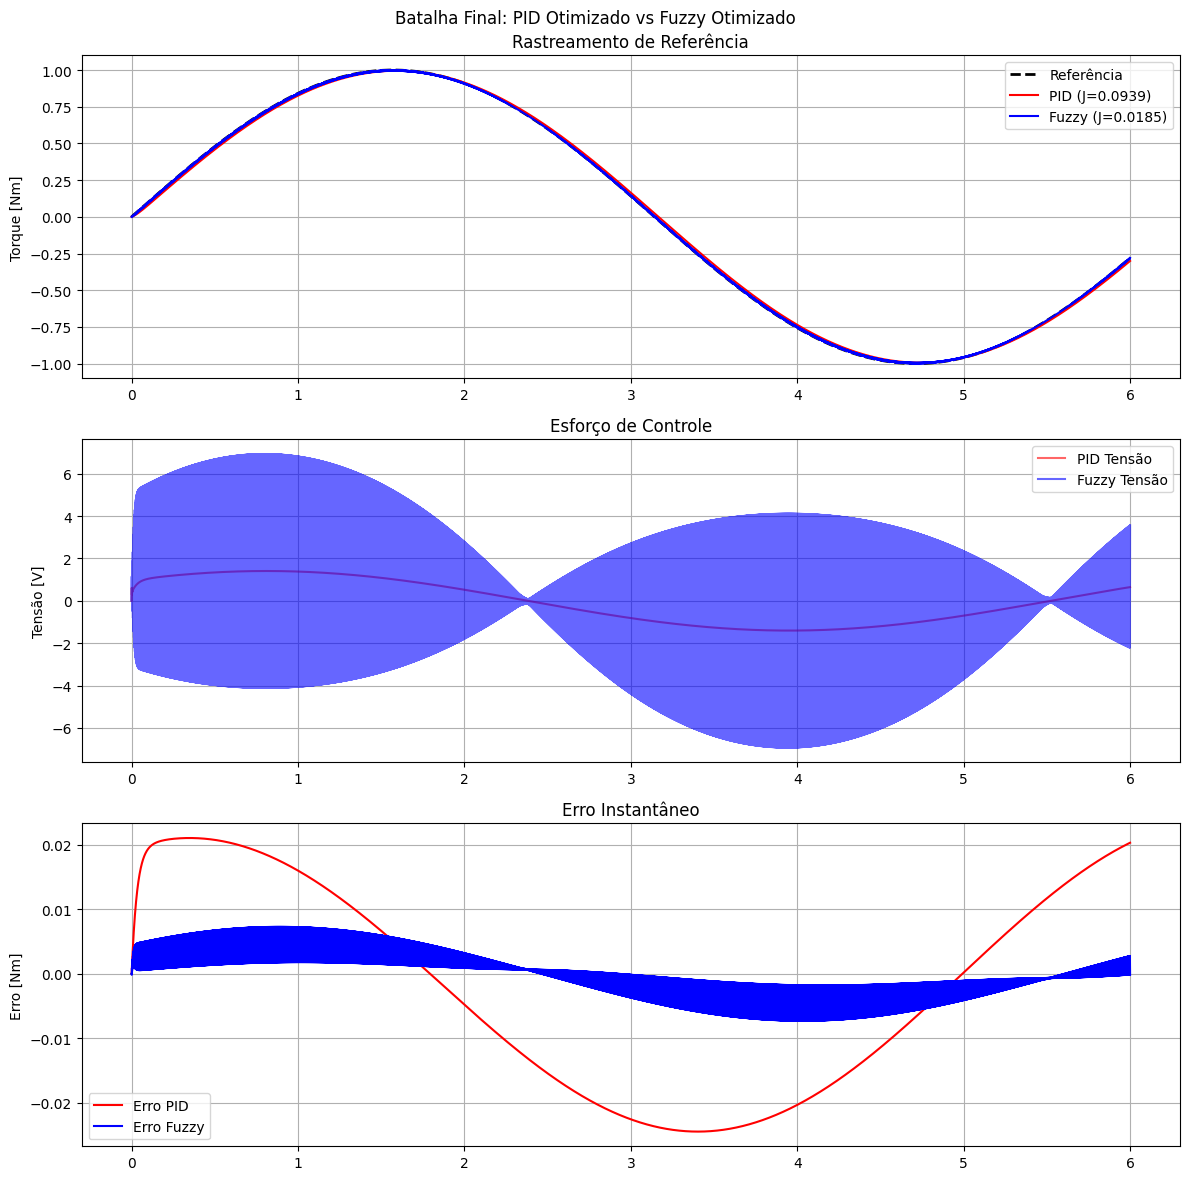

Controlador     | Custo (Goodhart) | Melhoria
---------------------------------------------
PID (GA)        | 0.0939          | -
Fuzzy (GA)      | 0.0185          | 80.34%


In [ ]:
# 1. Recriar a simulação PID com os melhores parâmetros encontrados (w_ga)
states_pid, u_pid = run_full_sim(w_ga) 

# 2. Simulação Fuzzy de Alta Precisão
# Precisamos de um integrador manual para o Fuzzy, pois o odeint 
# tem dificuldade em passar objetos complexos como classes.
# Faremos um Runge-Kutta 4 ou Euler melhorado manual para garantir justiça.

fuzzy_controller = FuzzyPD(w_fuzzy_opt)
states_fuzzy = np.zeros((n - 1, 2))
u_fuzzy_arr = np.zeros(n - 1)
x = 0
prev_error = 0

for i in range(n - 1):
    ref = torque_ref[i]
    error = ref - x
    
    if i == 0: derr = 0
    else: derr = (error - prev_error) / t_sim_step
        
    # Controle
    u = fuzzy_controller.calcular(error, derr)
    u = np.clip(u, -100, 100) # Saturação
    u_fuzzy_arr[i] = u
    
    # Planta (Euler para manter consistência com o PID cost function, 
    # mas idealmente seria RK4. Para o gráfico visual, Euler com passo pequeno (1ms) é suficiente)
    dx = -a * k * x + k * u
    x = x + dx * t_sim_step
    
    states_fuzzy[i, 0] = x
    prev_error = error

# 3. Plotagem Comparativa
fig5, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.suptitle("Batalha Final: PID Otimizado vs Fuzzy Otimizado")

# Torque
axs[0].plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Referência")
axs[0].plot(time_vector[:-1], states_pid[:, 0], "r", label=f"PID (J={cost_ga:.4f})")
axs[0].plot(time_vector[:-1], states_fuzzy[:, 0], "b", label=f"Fuzzy (J={cost_fuzzy_opt:.4f})")
axs[0].set_ylabel("Torque [Nm]")
axs[0].set_title("Rastreamento de Referência")
axs[0].legend()
axs[0].grid(True)

# Tensão (Esforço de Controle)
axs[1].plot(time_vector[:-1], u_pid, "r", alpha=0.6, label="PID Tensão")
axs[1].plot(time_vector[:-1], u_fuzzy_arr, "b", alpha=0.6, label="Fuzzy Tensão")
axs[1].set_ylabel("Tensão [V]")
axs[1].set_title("Esforço de Controle")
axs[1].legend()
axs[1].grid(True)

# Erro
erro_pid = torque_ref[:-1] - states_pid[:, 0]
erro_fuzzy = torque_ref[:-1] - states_fuzzy[:, 0]

axs[2].plot(time_vector[:-1], erro_pid, "r", label="Erro PID")
axs[2].plot(time_vector[:-1], erro_fuzzy, "b", label="Erro Fuzzy")
axs[2].set_ylabel("Erro [Nm]")
axs[2].set_title("Erro Instantâneo")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Comparação Numérica
print(f"{'Controlador':<15} | {'Custo (Goodhart)':<15} | {'Melhoria'}")
print("-" * 45)
print(f"{'PID (GA)':<15} | {cost_ga:<15.4f} | -")
print(f"{'Fuzzy (GA)':<15} | {cost_fuzzy_opt:<15.4f} | {((cost_ga - cost_fuzzy_opt)/cost_ga)*100:.2f}%")